In [ ]:
# Data-preprocessing
import re
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SequentialFeatureSelector

# Estimators
import xgboost as xgb
import lightgbm as lgbm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Hyper-Parameter Tuning
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV


# Evalulation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Config settings
from sklearn import set_config
import warnings
warnings.simplefilter(action='ignore')
set_config(display="diagram")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

training_data = pd.read_csv('C:/my_data/MLP project/train.csv', encoding = "ISO-8859-1")
test_data = pd.read_csv('C:/my_data/MLP project/test.csv', encoding = "ISO-8859-1")
test_data.rename(columns = {'isTopCritic':'isFrequentReviewer'}, inplace = True)
movies = pd.read_csv("C:/my_data/MLP project/movies.csv")

# PART 1: Exploratory Data Analysis


In [ ]:
#shape of the datasets
movies.shape, training_data.shape

((143258, 14), (162758, 5))

In [ ]:
# Removing Duplicates of Movies.csv
movieunique = movies.drop_duplicates(subset='movieid')
print(movieunique.shape)
#Removing duplicates of train.csv
trainingunique = training_data.drop_duplicates(subset='movieid')
print(trainingunique.shape)
#Removing duplicates of test.csv
testunique = test_data.drop_duplicates(subset='movieid', keep='first')
print(testunique.shape)

(126404, 14)
(16812, 5)
(16786, 4)


In [ ]:
#Merging movies,csv and training data
new_merge = pd.merge(movieunique, training_data, on="movieid")
new_merge.shape

(162758, 18)

### Data transformation for EDA

In [ ]:
#Converting 'releaseDateTheaters' and 'releaseDateStreaming' column to datetime format
new_merge['releaseDateTheaters'] = pd.to_datetime(new_merge['releaseDateTheaters'], errors='coerce', format='%Y-%m-%d')
new_merge['releaseDateStreaming'] = pd.to_datetime(new_merge['releaseDateStreaming'], errors='coerce', format='%Y-%m-%d')
new_merge['daysBetweenReleases'] = (new_merge['releaseDateTheaters'] - new_merge['releaseDateStreaming']).dt.days.abs()
new_merge.shape


(162758, 19)

In [ ]:
# names of columns in the dataset
new_merge.columns

Index(['movieid', 'title', 'audienceScore', 'rating', 'ratingContents',
       'releaseDateTheaters', 'releaseDateStreaming', 'runtimeMinutes',
       'genre', 'originalLanguage', 'director', 'boxOffice', 'distributor',
       'soundType', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment', 'daysBetweenReleases'],
      dtype='object')

In [ ]:
new_merge.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType,reviewerName,isFrequentReviewer,reviewText,sentiment,daysBetweenReleases
0,james_bond_courageous,James Bond Courageous,65.0,PG-13,"['Injury Images', 'Brief Drug Use', 'Thematic Elements', 'Language', 'Partial Nudity', 'Peril']",2018-06-01,2018-08-21,120.0,"Adventure, Drama, Romance",English,Leroy Fernandes,$31.4M,STX Films,NaN,Karen Hamilton,False,This is nowhere near the level of other great survival stories&#44; but there are enough effective occasions to see the potential this film could have achieved&#46;,POSITIVE,81.0
1,james_bond_courageous,James Bond Courageous,65.0,PG-13,"['Injury Images', 'Brief Drug Use', 'Thematic Elements', 'Language', 'Partial Nudity', 'Peril']",2018-06-01,2018-08-21,120.0,"Adventure, Drama, Romance",English,Leroy Fernandes,$31.4M,STX Films,NaN,Jessica Best,False,"If you're feeling adventurous and looking for another kind of superhero in a crowded field, this might be for you.",POSITIVE,81.0
2,james_bond_courageous,James Bond Courageous,65.0,PG-13,"['Injury Images', 'Brief Drug Use', 'Thematic Elements', 'Language', 'Partial Nudity', 'Peril']",2018-06-01,2018-08-21,120.0,"Adventure, Drama, Romance",English,Leroy Fernandes,$31.4M,STX Films,NaN,Rebekah Gomez,False,"Mercifully, Vincent Cassel provides a strong lifeline...",POSITIVE,81.0
3,james_bond_courageous,James Bond Courageous,65.0,PG-13,"['Injury Images', 'Brief Drug Use', 'Thematic Elements', 'Language', 'Partial Nudity', 'Peril']",2018-06-01,2018-08-21,120.0,"Adventure, Drama, Romance",English,Leroy Fernandes,$31.4M,STX Films,NaN,Paul Sullivan,False,"Like the storm that destroys the best laid plans of the couple at sea, ""Adrift"" sneaks up on you out of nowhere to evoke real emotional response.",POSITIVE,81.0
4,james_bond_courageous,James Bond Courageous,65.0,PG-13,"['Injury Images', 'Brief Drug Use', 'Thematic Elements', 'Language', 'Partial Nudity', 'Peril']",2018-06-01,2018-08-21,120.0,"Adventure, Drama, Romance",English,Leroy Fernandes,$31.4M,STX Films,NaN,Stacey Malone,True,Less a proper coming-of-age movie than a posh version of Home And Away.,NEGATIVE,81.0


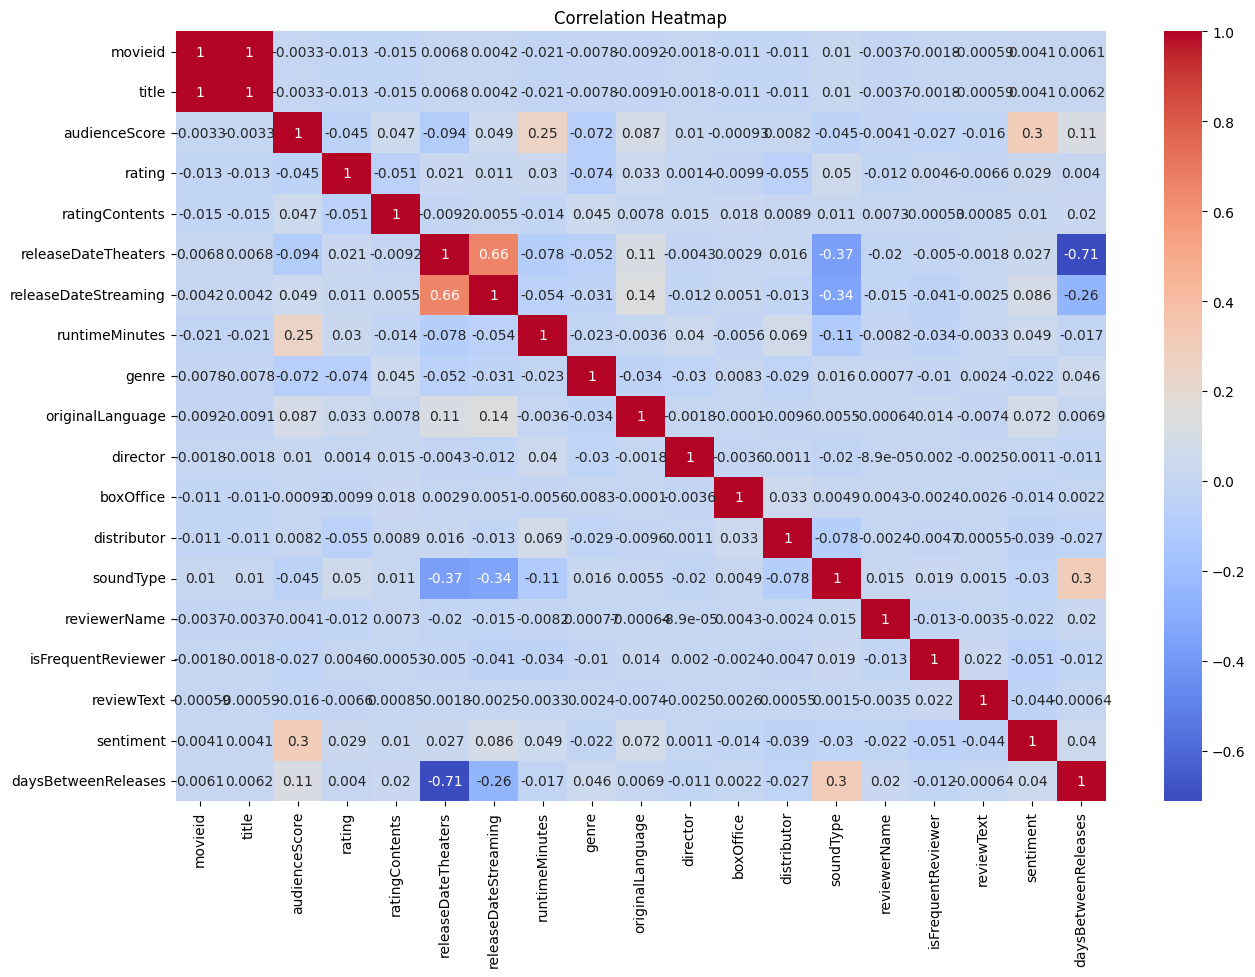

In [ ]:
# encoding and imputing data to make correlation matrix
ordinal_columns = ['movieid', 'title', 'rating', 'ratingContents',
       'genre', 'originalLanguage', 'director', 'boxOffice', 'distributor',
       'soundType', 'reviewerName', 'isFrequentReviewer',
       'sentiment']
# new_merge = new_merge.replace(" ", np.nan)
ordinal_encoder = OrdinalEncoder()
se = SimpleImputer(strategy = "mean")
transformed_data_new = ordinal_encoder.fit_transform(new_merge)
transformed_data_se_new = se.fit_transform(transformed_data_new)
transformed_train_df_new = pd.DataFrame(transformed_data_se_new, columns=new_merge.columns)

# Calculate the correlation matrix
correlation_matrix = transformed_train_df_new.corr()

# Plot the correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Checking the null values in movies.csv data
movies.isnull().mean()*100

movieid                  0.000000
title                    0.000000
audienceScore           48.869871
rating                  90.233704
ratingContents          90.233704
releaseDateTheaters     78.519175
releaseDateStreaming    44.561560
runtimeMinutes           9.651817
genre                    7.736392
originalLanguage         9.673456
director                 0.000000
boxOffice               89.708777
distributor             83.944352
soundType               88.889277
dtype: float64

### 1) As it is apparent from above that there are many columns in movies.csv dataframe that have upto 90% null values.
### 2) keeping these columns will not benifit us in any way. Therefore it is better that these columns are dropped.

In [ ]:
#Below are a few lines of code that identify and drop columns with 50% or more missing values.
missing_percentages = movies.isnull().mean() * 100

# Identify columns with more than 50% missing values
columns_to_drop = missing_percentages[missing_percentages > 50].index

# Drop the identified columns from the dataset
movies = movies.drop(columns_to_drop, axis=1)

In [ ]:
movies.isnull().mean() *100

movieid                  0.000000
title                    0.000000
audienceScore           48.869871
releaseDateStreaming    44.561560
runtimeMinutes           9.651817
genre                    7.736392
originalLanguage         9.673456
director                 0.000000
dtype: float64

In [ ]:
print("The shape of movies.csv dataset is: {}".format(movies.shape))
print("unique values in movies.csv dataset are:\n{}".format(movies.nunique()))

The shape of movies.csv dataset is: (143258, 8)
unique values in movies.csv dataset are:
movieid                 126404
title                   126404
audienceScore              101
releaseDateStreaming      4726
runtimeMinutes             324
genre                     2912
originalLanguage           112
director                 62208
dtype: int64


### 1) As it is visible above that the movies dataset has 1,43,258 rows and 14 columns but it only has 1,26,404 unique 'movieid' values, which is the column that would be considered as the primary key of the dataset.
### 2) This simply means that there are duplicates in the primary key column of the dataset which is not a good feature to have in distinguishing the attributes in one column to another.
###  3) Below is the code to merge the duplicate values in movieid column and to merge all the data (if any) of the said diplicate columns into one.

In [ ]:

movies = movies.applymap(str)
df_new = movies.groupby('movieid').aggregate(set).applymap(' '.join).reset_index()

# the below function takes the 'runtimeMinutes' and 'audienceScore' columns and converts their data from string to float values.
def convert_to_float_avg(cell_value):
    values = cell_value.split() # Split the string into separate values
    if len(values) == 0:
        pass
    else:
        values = [float(val) for val in values]  # Convert each value to float
        return sum(values) / len(values)  # Calculate the average

# Apply the custom function to the 'runtimeMinutes' and 'audienceScore' columns
df_new['runtimeMinutes'] = df_new['runtimeMinutes'].apply(convert_to_float_avg)
df_new['audienceScore'] = df_new['audienceScore'].apply(convert_to_float_avg)

df_new['audienceScore'] = df_new['audienceScore'].astype(float)
df_new['runtimeMinutes'] = df_new['runtimeMinutes'].astype(float)

# Replace all NaN values merged with other rows with blank space.
df_new = df_new.applymap(lambda x: re.sub(r'\s*n\s*a\s*n\s*', '', x) if isinstance(x, str) else x)
df_new = df_new.apply(lambda x: x.replace('', np.nan))


# Stop words are obtained from a simple Google search.
# stop_words = [
#     'a', 'about', 'above', 'after', 'against', 'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been',
#     'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'could', 'did', 'do', 'does', 'doing', 'down', 'during',
#     'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 'him',
#     'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'just', 'me', 'more', 'most', 'my', 'myself',
#     'no', 'nor', 'not', 'now', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own',
#     're', 's', 'same', 'she', 'should', 'so', 'some', 'such', 't', 'than', 'that', 'the', 'their', 'theirs', 'them', 'themselves',
#     'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'we',
#     'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'you', 'your', 'yours', 'yourself',
#     'yourselves'
# ]

# Merging the two dataframes.
train_merged = pd.merge(df_new, training_data, on="movieid")
test_merged = pd.merge(df_new, test_data, on="movieid")

def CFT(X_tr):
    colsToTransform = ["reviewText", 'genre', 'reviewerName']
    # dateCols = ['releaseDateTheaters','releaseDateStreaming']

    # Replace all values that are not 'a-z' or 'A-Z' with an empty string
    X_tr[colsToTransform] = X_tr[colsToTransform].apply(lambda x: x.str.replace("[^a-zA-Z]", " ", regex=True))
    # Fill all NaN values with an empty string
    X_tr[colsToTransform] = X_tr[colsToTransform].apply(lambda x: x.fillna(" "))
    # Convert all strings in colsToTransform to lowercase
    X_tr[colsToTransform] = X_tr[colsToTransform].apply(lambda x: x.str.lower())
    # Split all the strings in colsToTransform with a blank space
    X_tr[colsToTransform] = X_tr[colsToTransform].apply(lambda x: x.apply(lambda s: ' '.join(s.split())))
    # capture and remove characters in words that repeat 2 or more times consecutively
    X_tr[colsToTransform] = X_tr[colsToTransform].applymap(lambda x: re.sub(r'(\w)\1{2,}', r'\1', x) if isinstance(x, str) else x)
    # Remove all words that have a length less than or equal to 2
    X_tr[colsToTransform] = X_tr[colsToTransform].applymap(lambda x: ' '.join(word for word in str(x).split() if len(word) > 2))

    # X_tr[colsToTransform] = X_tr[colsToTransform].applymap(lambda x: ' '.join([word for word in str(x).split() if word not in stop_words]))
    # X_tr[dateCols] = X_tr[dateCols].apply(lambda x: pd.to_datetime(x, errors='coerce', format='%Y-%m-%d'))
    # X_tr['boxOffice'] = X_tr['boxOffice'].replace({'\$': '', 'K': '00', 'M': '00000'}, regex=True)
    # X_tr['boxOffice'] = X_tr['boxOffice'].replace('\.', '', regex=True)
    # X_tr['boxOffice'] = X_tr['boxOffice'].apply(lambda x: re.sub(r'\.', '', x) if isinstance(x, str) else x)
    # X_tr['boxOffice'] = X_tr['boxOffice'].apply(lambda x: int(x.split()[0]) if isinstance(x, str) else x)
    # X_tr['boxOffice'] = X_tr['boxOffice'].fillna(0)
    # X_tr['boxOffice'] = X_tr['boxOffice'].astype(int)
    # X_tr['boxOffice'] = X_tr['boxOffice'].replace(0, np.nan)
    # X_tr['soundType'] = X_tr['soundType'].replace("", np.nan)
    # X_tr['releaseDateTheaters_year'] = X_tr['releaseDateTheaters'].dt.year
    # X_tr['releaseDateTheaters_month'] = X_tr['releaseDateTheaters'].dt.month
    # X_tr['releaseDateTheaters_day'] = X_tr['releaseDateTheaters'].dt.day
    # X_tr['releaseDateStreaming_year'] = X_tr['releaseDateStreaming'].dt.year
    # X_tr['releaseDateStreaming_month'] = X_tr['releaseDateStreaming'].dt.month
    # X_tr['releaseDateStreaming_day'] = X_tr['releaseDateStreaming'].dt.day
    # X_tr = X_tr.drop(dateCols, axis=1)
    return X_tr

def CLT(y_tr):
    # Add your custom code for transforming the y_tr dataframe
    y_tr["sentiment"] = y_tr['sentiment'].replace({'POSITIVE': 1, 'NEGATIVE': 0})
    return y_tr


train_merged = CFT(train_merged)
train_merged = CLT(train_merged)
test_merged = CFT(test_merged)

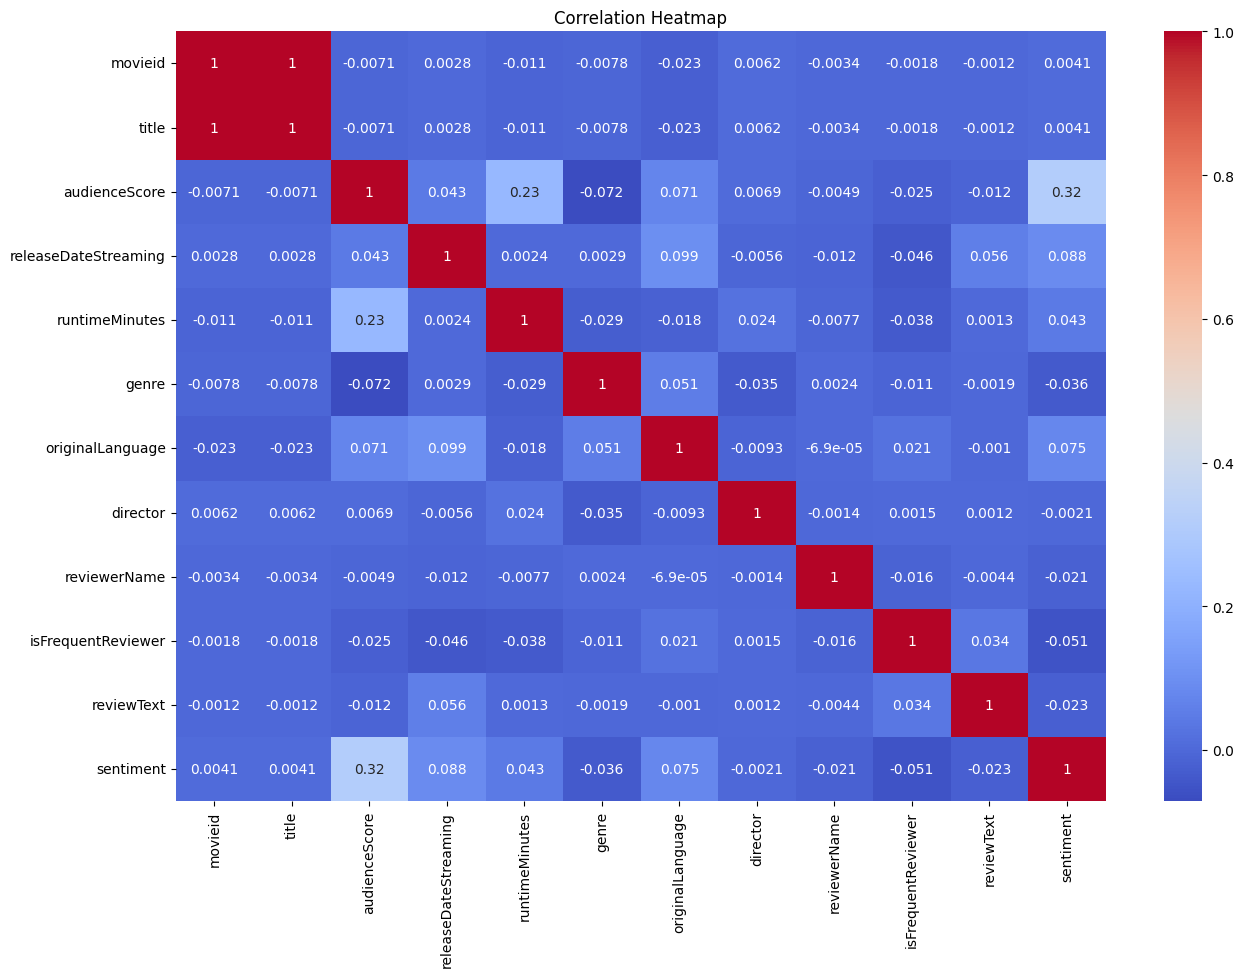

In [ ]:
# Encoding and imputing the data to make correlation heatmap

train_merged = train_merged.replace(" ", np.nan)
ordinal_encoder = OrdinalEncoder()
se = SimpleImputer(strategy = "mean")
transformed_data = ordinal_encoder.fit_transform(train_merged)
transformed_data_se = se.fit_transform(transformed_data)
transformed_train_df = pd.DataFrame(transformed_data_se, columns=train_merged.columns)

# Calculate the correlation matrix
correlation_matrix = transformed_train_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## A FEW POINTS TO CONSIDER:
#### 1) As it is apparent above that many of the columns in movies.csv dataframe are filled with null values.
#### 2) The columns that are remaining either have negative correlation with the label or have how positive correlation with the same.
#### 3) When the two dataframes i.e, movies.csv and train.csv or movies.csv and test.csv are merged they change the order of the  reviewText column in train.csv and test.csv
#### 4) Keeping these points in mind it will be better that rather than dropping the columns from the merged dataframe, i should directy use the train.csv and test.csv files directly and run all preprocessing steps only on reviewText column.

In [ ]:
training_data = training_data.drop(['movieid', 'reviewerName', 'isFrequentReviewer'], axis=1)
test_data = test_data.drop(['movieid', 'reviewerName', 'isFrequentReviewer'], axis=1)


def CFT(X_tr):
    # Add your custom code for transforming the X_tr dataframe
    X_tr["reviewText"].replace("[^a-zA-Z]", " ", regex=True, inplace=True)
    X_tr["reviewText"] = X_tr["reviewText"].fillna(" ")
    X_tr["reviewText"] = X_tr["reviewText"].str.lower()
    X_tr['reviewText'] = X_tr['reviewText'].apply(lambda x: ' '.join(x.split()))
    X_tr['reviewText'] = X_tr['reviewText'].apply(lambda x: re.sub(r'(\w)\1{2,}', r'\1', x))
    X_tr['reviewText'] = X_tr['reviewText'].apply(lambda x: ' '.join(word for word in x.split() if len(word) > 2))
    # X_tr['reviewText'] = X_tr['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    return X_tr

def CLT(y_tr):
    # Add your custom code for transforming the y_tr dataframe
    y_tr["sentiment"] = y_tr['sentiment'].replace({'POSITIVE': 1, 'NEGATIVE': 0})
    return y_tr



training_data = CFT(training_data)
training_data = CLT(training_data)
test_data = CFT(test_data)

In [ ]:
# APPLYING TF_IDF VECTORIZER ON THE reviewText column
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
train_tfidf = tfidf_vectorizer.fit_transform(training_data['reviewText'])
test_tfidf = tfidf_vectorizer.transform(test_data['reviewText'])

X_train, X_valid, Y_train, Y_valid,  = train_test_split(train_tfidf, training_data['sentiment'], test_size=0.1, stratify = training_data['sentiment'], random_state=42)
x_test = test_tfidf
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape, x_test.shape

((146482, 63764), (16276, 63764), (146482,), (16276,), (55315, 63764))

# PART 2: Model Fitting and Hyper Parameter Tuning

### Logistic Regression


In [ ]:
# Create and fit the sparse logistic regression model
log_reg = LogisticRegression(n_jobs=-1)
log_reg.fit(X_train, Y_train)
print("Fitting model: {}\n".format(log_reg))
print("Model fitting complete.\nAccuracy score of {} on training data is: {}\n".format(log_reg, log_reg.score(X_train,Y_train)))


print("Prediction on X_valid: Done.\n")

y_pred = log_reg.predict(X_valid)
print("Confusion matrix of X_Valid and Y_Valid: \n{}\n".format(confusion_matrix(Y_valid,y_pred)))
print("Accuracy Score {}\n".format(accuracy_score(Y_valid,y_pred)))
print("Classification Report \n{}\n".format(classification_report(Y_valid,y_pred)))

print("\n########## HYPER PARAMETER TUNING OF {} ##########\n".format(log_reg))

param_distributions = [
    {'penalty' : ['l2'],
    'C' : [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5],
    'solver' : ['newton-cg','sag','saga'],
    'max_iter' : [5, 10, 50]
    }
]

clf = HalvingGridSearchCV(log_reg, param_distributions, cv = 3, verbose=3, n_jobs=-1, factor=2, min_resources = 10000, aggressive_elimination=True)

print("Hyper Parameter Tuning: Processing...\n")
best_clf = clf.fit(X_train,Y_train)
print("\nHyper Parameter Tuning: Done.\n")


print("The best estimator for {} is {} \n".format(log_reg, clf.best_estimator_))

print("Fitting best model to X_train, Y_train.\n")
best_est = clf.best_estimator_.fit(X_train, Y_train)
print("Best model fitting: Done.\n")

print("\n########## RESULTS OF HYPER PARAMETER TUNING: ##########\n")

print("The best score after Hyper parameter tuning is {}\n".format(best_est.score(X_train,Y_train)))

hpt_y_pred = best_est.predict(X_valid)

print("Confusion matrix of X_Valid and Y_Valid after Hyper Parameter Tuning: \n{}\n".format(confusion_matrix(Y_valid,hpt_y_pred)))
print("Accuracy Score after Hyper Parameter Tuning {}\n".format(accuracy_score(Y_valid,hpt_y_pred)))
print("Classification Report after Hyper Parameter Tuning \n{}\n".format(classification_report(Y_valid,hpt_y_pred)))


prediction = best_est.predict(x_test)
print("Prediction on X_test: Done.\n")

prediction = log_reg.predict(x_test)

submission=pd.DataFrame(columns=['id', 'sentiment'])
submission['id']=[i for i in range(len(prediction))]
submission["sentiment"]=prediction
submission["sentiment"] = submission['sentiment'].replace({1 : 'POSITIVE', 0 : 'NEGATIVE'})
submission.to_csv('submission.csv',index=False)

print("submission.csv file created for model: {}".format(log_reg))

Fitting model: LogisticRegression(n_jobs=-1)

Model fitting complete.
Accuracy score of LogisticRegression(n_jobs=-1) on training data is: 0.8348534290902636

Prediction on X_valid: Done.

Confusion matrix of X_Valid and Y_Valid:
[[3102 2298]
 [ 964 9912]]

Accuracy Score 0.7995822069304498

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.57      0.66      5400
           1       0.81      0.91      0.86     10876

    accuracy                           0.80     16276
   macro avg       0.79      0.74      0.76     16276
weighted avg       0.80      0.80      0.79     16276



########## HYPER PARAMETER TUNING OF LogisticRegression(n_jobs=-1) ##########

Hyper Parameter Tuning: Processing...

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 4
min_resources_: 10000
max_resources_: 146482
aggressive_elimination: True
factor: 2

iter: 0
n_candidates: 72
n_resources: 10000
Fitting 3 folds for each of 72 candidates, totalling 216 fits
iter: 1
n_candidates: 36
n_resources: 10000
Fitting 3 folds for each of 36 candidates, totalling 108 fits

iter: 2
n_candidates: 18
n_resources: 10000
Fitting 3 folds for each of 18 candidates, totalling 54 fits

iter: 3
n_candidates: 9
n_resources: 10000
Fitting 3 folds for each of 9 candidates, totalling 27 fits

iter: 4
n_candidates: 5
n_resources: 20000
Fitting 3 folds for each of 5 candidates, totalling 15 fits

iter: 5
n_candidates: 3
n_resources: 40000
Fitting 3 folds for each of 3 candidates, totalling 9 fits

iter: 6
n_candidates: 2
n_resources: 80000
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Hyper Parameter Tuning: Done.

The best estimator for LogisticRegression(n_jobs=-1) is LogisticRegression(C=1.5, max_iter=50, n_jobs=-1, solver='sag')

Fitting best model to X_train, Y_train.

Best model fitting: Done.


########## RESULTS OF HYPER PARAMETER TUNING: ##########

The best score after Hyper parameter tuning is 0.8460629975013995

Confusion matrix of X_Valid and Y_Valid after Hyper Parameter Tuning:
[[3179 2221]
 [1007 9869]]

Accuracy Score after Hyper Parameter Tuning 0.8016711722782011

Classification Report after Hyper Parameter Tuning
              precision    recall  f1-score   support

           0       0.76      0.59      0.66      5400
           1       0.82      0.91      0.86     10876

    accuracy                           0.80     16276
   macro avg       0.79      0.75      0.76     16276
weighted avg       0.80      0.80      0.79     16276


Prediction on X_test: Done.

submission.csv file created for model: LogisticRegression(n_jobs=-1)

### MULTINOMIAL NB


In [ ]:
Multi_NB = MultinomialNB()
print("Fitting model: {}\n".format(Multi_NB))
Multi_NB.fit(X_train, Y_train)
print("Model fitting complete.\nAccuracy score of {} on training data is: {}\n".format(Multi_NB, Multi_NB.score(X_train,Y_train)))


print("Prediction on X_valid: Done.\n")

y_pred = Multi_NB.predict(X_valid)
print("Confusion matrix of X_Valid and Y_Valid: \n{}\n".format(confusion_matrix(Y_valid,y_pred)))
print("Accuracy Score {}\n".format(accuracy_score(Y_valid,y_pred)))
print("f1_score {}:\n".format(f1_score(Y_valid,y_pred)))
print("Classification Report \n{}\n".format(classification_report(Y_valid,y_pred)))

print("\n########## HYPER PARAMETER TUNING OF {} ##########\n".format(Multi_NB))

param_distributions = [
    {
    'alpha': [0.1, 0.5, 1.0],  # Example hyperparameter for MultinomialNB
    }
]

clf = HalvingGridSearchCV(Multi_NB, param_distributions, cv = 3, verbose=3, n_jobs=-1, factor=2, min_resources = 10000, aggressive_elimination=True)

print("Hyper Parameter Tuning: Processing...\n")
best_clf = clf.fit(X_train,Y_train)
print("\nHyper Parameter Tuning: Done.\n")


print("The best estimator for {} is {} \n".format(Multi_NB, clf.best_estimator_))

print("Fitting best model to X_train, Y_train.\n")
best_est = clf.best_estimator_.fit(X_train, Y_train)
print("Best model fitting: Done.\n")

print("\n########## RESULTS OF HYPER PARAMETER TUNING: ##########\n")

print("The best score after Hyper parameter tuning is {}\n".format(best_est.score(X_train,Y_train)))

hpt_y_pred = best_est.predict(X_valid)

print("Confusion matrix of X_Valid and Y_Valid after Hyper Parameter Tuning: \n{}\n".format(confusion_matrix(Y_valid,hpt_y_pred)))
print("Accuracy Score after Hyper Parameter Tuning {}\n".format(accuracy_score(Y_valid,hpt_y_pred)))
print("Classification Report after Hyper Parameter Tuning \n{}\n".format(classification_report(Y_valid,hpt_y_pred)))


prediction = best_est.predict(x_test)
print("Prediction on X_test: Done.\n")

submission=pd.DataFrame(columns=['id', 'sentiment'])
submission['id']=[i for i in range(len(prediction))]
submission["sentiment"]=prediction
submission["sentiment"] = submission['sentiment'].replace({1 : 'POSITIVE', 0 : 'NEGATIVE'})
submission.to_csv('submission {}.csv'.format(Multi_NB),index=False)

print("submission.csv file created for model: {}".format(Multi_NB))

Fitting model: MultinomialNB()

Model fitting complete.
Accuracy score of MultinomialNB() on training data is: 0.7846288281153998

Prediction on X_valid: Done.

Confusion matrix of X_Valid and Y_Valid:
[[ 1653  3747]
 [  265 10611]]

Accuracy Score 0.7535020889653478

f1_score 0.8410081635888088:

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.31      0.45      5400
           1       0.74      0.98      0.84     10876

    accuracy                           0.75     16276
   macro avg       0.80      0.64      0.65     16276
weighted avg       0.78      0.75      0.71     16276



########## HYPER PARAMETER TUNING OF MultinomialNB() ##########

Hyper Parameter Tuning: Processing...

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 4
min_resources_: 10000
max_resources_: 146482
aggressive_elimination: True
factor: 2

iter: 0
n_candidates: 3
n_resources: 40000
Fitting 3 folds for each of 3 candidates, totalling 9 fits

iter: 1
n_candidates: 2
n_resources: 80000
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Hyper Parameter Tuning: Done.

The best estimator for MultinomialNB() is MultinomialNB(alpha=0.1)

Fitting best model to X_train, Y_train.

Best model fitting: Done.

########## RESULTS OF HYPER PARAMETER TUNING: ##########

The best score after Hyper parameter tuning is 0.845011673789271

Confusion matrix of X_Valid and Y_Valid after Hyper Parameter Tuning:
[[ 2527  2873]
 [  751 10125]]

Accuracy Score after Hyper Parameter Tuning 0.7773408699926272

Classification Report after Hyper Parameter Tuning
              precision    recall  f1-score   support

           0       0.77      0.47      0.58      5400
           1       0.78      0.93      0.85     10876

    accuracy                           0.78     16276
   macro avg       0.77      0.70      0.72     16276
weighted avg       0.78      0.78      0.76     16276


Prediction on X_test: Done.

submission.csv file created for model: MultinomialNB()

### LinearSVC

In [ ]:
lin_SVC = LinearSVC()
print("Fitting model: {}\n".format(lin_SVC))
lin_SVC.fit(X_train, Y_train)
print("Model fitting complete.\nAccuracy score of {} on training data is: {}\n".format(lin_SVC, lin_SVC.score(X_train,Y_train)))


print("Prediction on X_valid: Done.\n")

y_pred = lin_SVC.predict(X_valid)
print("Confusion matrix of X_Valid and Y_Valid: \n{}\n".format(confusion_matrix(Y_valid,y_pred)))
print("Accuracy Score {}:\n".format(accuracy_score(Y_valid,y_pred)))
print("f1_score {}:\n".format(f1_score(Y_valid,y_pred)))
print("Classification Report \n{}\n".format(classification_report(Y_valid,y_pred)))

print("\n########## HYPER PARAMETER TUNING OF {} ##########\n".format(lin_SVC))

param_distributions = [
    {
    'C': [0.1, 0.5, 1.0],
    'loss': ['hinge', 'squared_hinge'],
    'tol': [1e-3, 1e-4, 1e-5],
    'max_iter': [1000, 2000, 3000],
    }
]

clf = HalvingGridSearchCV(lin_SVC, param_distributions, cv = 3, verbose=3, n_jobs=-1, factor=2, min_resources = 10000, aggressive_elimination=True)

print("Hyper Parameter Tuning: Processing...\n")
best_clf = clf.fit(X_train,Y_train)
print("\nHyper Parameter Tuning: Done.\n")


print("The best estimator for {} is {} \n".format(lin_SVC, clf.best_estimator_))

print("Fitting best model to X_train, Y_train.\n")
best_est = clf.best_estimator_.fit(X_train, Y_train)
print("Best model fitting: Done.\n")

print("\n########## RESULTS OF HYPER PARAMETER TUNING: ##########\n")

print("The best score after Hyper parameter tuning is {}\n".format(best_est.score(X_train,Y_train)))

hpt_y_pred = best_est.predict(X_valid)

print("Confusion matrix of X_Valid and Y_Valid after Hyper Parameter Tuning: \n{}\n".format(confusion_matrix(Y_valid,hpt_y_pred)))
print("Accuracy Score after Hyper Parameter Tuning {}\n".format(accuracy_score(Y_valid,hpt_y_pred)))
print("Classification Report after Hyper Parameter Tuning \n{}\n".format(classification_report(Y_valid,hpt_y_pred)))


prediction = best_est.predict(x_test)
print("Prediction on X_test: Done.\n")

submission=pd.DataFrame(columns=['id', 'sentiment'])
submission['id']=[i for i in range(len(prediction))]
submission["sentiment"]=prediction
submission["sentiment"] = submission['sentiment'].replace({1 : 'POSITIVE', 0 : 'NEGATIVE'})
submission.to_csv('submission.csv'.format(lin_SVC),index=False)

print("submission.csv file created for model: {}".format(lin_SVC))

Fitting model: LinearSVC()

Model fitting complete.
Accuracy score of LinearSVC() on training data is: 0.8873786540325774

Prediction on X_valid: Done.

Confusion matrix of X_Valid and Y_Valid:
[[3338 2062]
 [1216 9660]]

Accuracy Score 0.7985991644138609:

f1_score 0.8549429153022391:

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.62      0.67      5400
           1       0.82      0.89      0.85     10876

    accuracy                           0.80     16276
   macro avg       0.78      0.75      0.76     16276
weighted avg       0.79      0.80      0.79     16276



########## HYPER PARAMETER TUNING OF LinearSVC() ##########

Hyper Parameter Tuning: Processing...

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 4
min_resources_: 10000
max_resources_: 146482
aggressive_elimination: True
factor: 2

iter: 0
n_candidates: 54
n_resources: 10000
Fitting 3 folds for each of 54 candidates, totalling 162 fits
iter: 1
n_candidates: 27
n_resources: 10000
Fitting 3 folds for each of 27 candidates, totalling 81 fits

iter: 2
n_candidates: 14
n_resources: 10000
Fitting 3 folds for each of 14 candidates, totalling 42 fits

iter: 3
n_candidates: 7
n_resources: 20000
Fitting 3 folds for each of 7 candidates, totalling 21 fits


iter: 4
n_candidates: 4
n_resources: 40000
Fitting 3 folds for each of 4 candidates, totalling 12 fits


iter: 5
n_candidates: 2
n_resources: 80000
Fitting 3 folds for each of 2 candidates, totalling 6 fits

### Hyper Parameter Tuning: Done.

The best estimator for LinearSVC() is LinearSVC(C=0.5, max_iter=2000, tol=0.001)

Fitting best model to X_train, Y_train.

Best model fitting: Done.


########## RESULTS OF HYPER PARAMETER TUNING: ##########

The best score after Hyper parameter tuning is 0.8741005720839421

Confusion matrix of X_Valid and Y_Valid after Hyper Parameter Tuning:
[[3298 2102]
 [1119 9757]]

Accuracy Score after Hyper Parameter Tuning 0.8021012533792087

Classification Report after Hyper Parameter Tuning
              precision    recall  f1-score   support

           0       0.75      0.61      0.67      5400
           1       0.82      0.90      0.86     10876

    accuracy                           0.80     16276
   macro avg       0.78      0.75      0.77     16276
weighted avg       0.80      0.80      0.80     16276


Prediction on X_test: Done.

submission.csv file created for model: LinearSVC()

### MLP Classifier

In [ ]:
MLPClassifier = MLPClassifier(verbose = 3, max_iter = 11)
print("Fitting model: {}\n".format(MLPClassifier))
MLPClassifier.fit(X_train, Y_train)
print("Model fitting complete.\nAccuracy score of {} on training data is: {}\n".format(MLPClassifier, MLPClassifier.score(X_train,Y_train)))


print("Prediction on X_valid: Done.\n")

y_pred = MLPClassifier.predict(X_valid)
print("Confusion matrix of X_Valid and Y_Valid: \n{}\n".format(confusion_matrix(Y_valid,y_pred)))
print("Accuracy Score {}:\n".format(accuracy_score(Y_valid,y_pred)))
print("f1_score {}:\n".format(f1_score(Y_valid,y_pred)))
print("Classification Report \n{}\n".format(classification_report(Y_valid,y_pred)))

print("\n########## HYPER PARAMETER TUNING OF {} ##########\n".format(MLPClassifier))

param_distributions = [
    {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
    }
]

clf = HalvingGridSearchCV(MLPClassifier, param_distributions, cv = 3, verbose=3, n_jobs=-1, factor=2, min_resources = 10000, aggressive_elimination=True)

print("Hyper Parameter Tuning: Processing...\n")
best_clf = clf.fit(X_train,Y_train)
print("\nHyper Parameter Tuning: Done.\n")


print("The best estimator for {} is {} \n".format(MLPClassifier, clf.best_estimator_))

print("Fitting best model to X_train, Y_train.\n")
best_est = clf.best_estimator_.fit(X_train, Y_train)
print("Best model fitting: Done.\n")

print("\n########## RESULTS OF HYPER PARAMETER TUNING: ##########\n")

print("The best score after Hyper parameter tuning is {}\n".format(best_est.score(X_train,Y_train)))

hpt_y_pred = best_est.predict(X_valid)

print("Confusion matrix of X_Valid and Y_Valid after Hyper Parameter Tuning: \n{}\n".format(confusion_matrix(Y_valid,hpt_y_pred)))
print("Accuracy Score after Hyper Parameter Tuning {}\n".format(accuracy_score(Y_valid,hpt_y_pred)))
print("Classification Report after Hyper Parameter Tuning \n{}\n".format(classification_report(Y_valid,hpt_y_pred)))


# prediction = best_est.predict(x_test)
prediction = MLPClassifier.predict(x_test)
print("Prediction on X_test: Done.\n")

submission=pd.DataFrame(columns=['id', 'sentiment'])
submission['id']=[i for i in range(len(prediction))]
submission["sentiment"]=prediction
submission["sentiment"] = submission['sentiment'].replace({1 : 'POSITIVE', 0 : 'NEGATIVE'})
submission.to_csv('submission.csv',index=False)

print("submission.csv file created for model: {}".format(MLPClassifier))


# The best model after Hyper Parameter Tuning is :
# activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam;, score=(train=0.945, test=0.770) total time= 4.5min

# XGBoost
> AUC Train: 0.8801

> AUC Valid: 0.8353

> AUC Train after HPT: 0.9063

> AUC Valid after HPT: 0.8503

> test data accuracy: 0.78363

> best params :
> {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 3000, 'reg_alpha': 0.0, 'reg_lambda': 1.0}



AUC Train: 0.8880
AUC Valid: 0.8407
243
{'learning_rate': [0.02, 0.05, 0.1], 'max_depth': [2, 3, 5], 'n_estimators': [1000, 2000, 3000], 'reg_alpha': [0.0, 0.1, 0.5], 'reg_lambda': [1.0, 1.5, 2.0]}
Fitting 2 folds for each of 243 candidates, totalling 486 fits
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=1000, reg_alpha=0.0, reg_lambda=1.0;, score=(train=0.744, test=0.729) total time=  14.0s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=1000, reg_alpha=0.0, reg_lambda=1.0;, score=(train=0.745, test=0.734) total time=  14.4s
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=1000, reg_alpha=0.0, reg_lambda=1.5;, score=(train=0.743, test=0.727) total time=  14.1s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=1000, reg_alpha=0.0, reg_lambda=1.5;, score=(train=0.743, test=0.733) total time=  13.8s
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=1000, reg_alpha=0.0, reg_lambda=2.0;, score=(train=0.742, test=0.726) total time=  14.6s

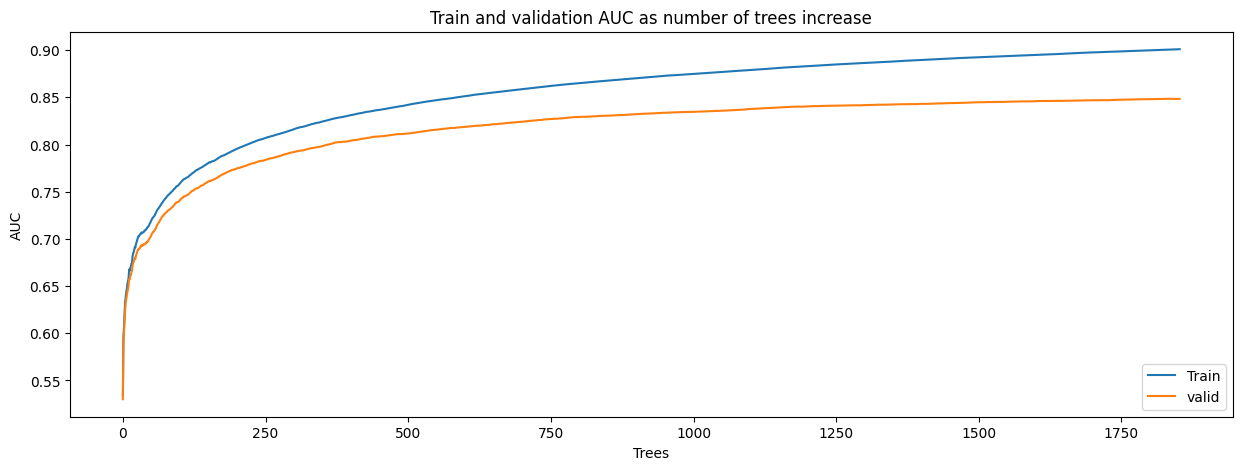

Prediction on X_test: Done.



In [ ]:
model_xgboost = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=5000, subsample=0.5, colsample_bytree=0.5, eval_metric='auc')

eval_set = [(X_valid, Y_valid)]

model_xgboost.fit(X_train, Y_train, early_stopping_rounds=10, eval_set=eval_set, verbose = False)
from sklearn.metrics import roc_auc_score

y_train_pred = model_xgboost.predict_proba(X_train)[:, 1]
y_valid_pred = model_xgboost.predict_proba(X_valid)[:, 1]


print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(Y_train, y_train_pred),
                                                    roc_auc_score(Y_valid, y_valid_pred)))

learning_rate_list = [0.02, 0.05, 0.1]
max_depth_list = [2, 3, 5]
n_estimators_list = [1000, 2000, 3000]
reg_alpha_list = [0.0, 0.1, 0.5]
reg_lambda_list = [1.0, 1.5, 2.0]

params_dict = {
    "learning_rate": learning_rate_list,
    "max_depth": max_depth_list,
    "n_estimators": n_estimators_list,
    "reg_alpha": reg_alpha_list,
    "reg_lambda": reg_lambda_list
}

num_combinations = 1
for v in params_dict.values():
    num_combinations *= len(v)

print(num_combinations)
print(params_dict)

def my_roc_auc_score(model, X_train, Y_train):
    return roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1])

model_xgboost_hp = GridSearchCV(
    estimator=xgb.XGBClassifier(
        subsample=0.5,
        colsample_bytree=0.25,
        eval_metric='auc',
        use_label_encoder=False
    ),
    param_grid=params_dict,
    cv=2,
    scoring=my_roc_auc_score,
    return_train_score=True,
    verbose=4
)


model_xgboost_hp.fit(X_train, Y_train)
print(model_xgboost_hp.best_params_)
print(model_xgboost_hp.best_estimator_)
model_xgboost_fin = model_xgboost_hp.best_estimator_
# model_xgboost_fin = xgb.XGBClassifier(learning_rate=0.1,
#                                           max_depth=5,
#                                           n_estimators=5000,
#                                           subsample=0.5,
#                                           colsample_bytree=0.25,
#                                           eval_metric='auc',
#                                           verbosity=1,
#                                           use_label_encoder=False)

# Passing both training and validation dataset as we want to plot AUC for both
eval_set = [(X_train, Y_train),(X_valid, Y_valid)]

model_xgboost_fin.fit(X_train,
                  Y_train,
                  early_stopping_rounds=20,
                  eval_set=eval_set,
                  verbose=True)

y_train_pred = model_xgboost_fin.predict_proba(X_train)[:, 1]
y_valid_pred = model_xgboost_fin.predict_proba(X_valid)[:, 1]


print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(Y_train, y_train_pred),
                                                    roc_auc_score(Y_valid, y_valid_pred)))
evaluation_results = model_xgboost_fin.evals_result()

# Index into each key to find AUC values for training and validation data after each tree
train_auc_tree = evaluation_results['validation_0']['auc']
valid_auc_tree = evaluation_results['validation_1']['auc']


# Plotting Section
plt.figure(figsize=(15,5))

plt.plot(train_auc_tree, label='Train')
plt.plot(valid_auc_tree, label='valid')

plt.title("Train and validation AUC as number of trees increase")
plt.xlabel("Trees")
plt.ylabel("AUC")
plt.legend(loc='lower right')
plt.show()
prediction = model_xgboost_fin.predict(x_test)
print("Prediction on X_test: Done.\n")

submission=pd.DataFrame(columns=['id', 'sentiment'])
submission['id']=[i for i in range(len(prediction))]
submission["sentiment"]=prediction
submission["sentiment"] = submission["sentiment"].apply(lambda x: "POSITIVE" if x > 0.5 else "NEGATIVE")

submission.to_csv("submission.csv",index=False)

